In [1]:
#access reddit
#access subreddit
#access threads
#scrape top threads top comments
#label the sentiment of each words, create word cloud on positive and negative words
#create a column with label of negative to positive comments
#understand panda data structure
#find positive words
#find negative words
#submission = reddit thread

In [1]:
import praw #reddit scraper
import pandas as pd #dataframe to organize data
import getpass #hiding password and login credentials
from datetime import datetime #for converting datetime from reddit time object
import pprint #use to check functionality of praw objects
import string #use to clean punctuations

In [2]:
from wordcloud import WordCloud #use to create wordcloud
import matplotlib.pyplot as plt #library for visualizations
plt.style.use('fivethirtyeight')
import getpass

In [3]:
#importing and using nltk library for text analysis
from nltk.tokenize import sent_tokenize #for sentence tokenizing
from nltk.tokenize import word_tokenize #splitting up the words into individual object
from nltk.corpus import stopwords #Examples of stop words in English are “a”, “the”, “is”, “are” and etc
from nltk.stem import PorterStemmer #root word
from nltk.stem import WordNetLemmatizer #sort words by grouping inflected or variant forms of the same word
from nltk.stem import wordnet #needed for lemmatizing words
from nltk.probability import FreqDist #count distribution of words
from nltk.util import bigrams, trigrams, ngrams #analyzing consecutive uses of words
import seaborn as sns #used for barchart
from nltk import pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer

In [3]:
#client_id = getpass.getpass("Client ID:")
#client_secret = getpass.getpass("Client Secret:")
#username = getpass.getpass("Username:")
#password = getpass.getpass("Password")

Client ID:········


In [7]:
#defining scrape api created in reddit
user_agent = 'Scrape Bot'

In [8]:
#gaining access into reddit
reddit = praw.Reddit(client_id='66sWXVKNl1UwjWzCojLxAA', client_secret='tJDq7SGMCWgCku5aFZLu7N9_e_25QQ',user_agent='Scrape Bot')

In [9]:
#defining subreddit
antiwork_sub = reddit.subreddit('antiwork')

In [10]:
#Gathering thread information and top posts. Also defining how many top posts to grab
posts = []
for post in antiwork_sub.top("all",limit=200):
    posts.append([post.title,datetime.utcfromtimestamp(post.created).strftime('%Y-%m-%d %H:%M:%S'),post.permalink])

In [11]:
#organizing thread information into panda dataframe
posts = pd.DataFrame(posts,columns=['title','created','link'])

In [12]:
#gathering top level 1 comments from reddit posts, capping at 25
comments_data = []

for each_post in posts.link: #looping through each url link to get inside each post
    submission = reddit.submission(url="https://www.reddit.com" + each_post)
    submission.comment_sort = 'top' #sorting comments by top
    #submission.comment_limit = 25
    submission.comments.replace_more(limit=0) #removing replies from comments
    comment_list = submission.comments.list() #converting comment objects into list
    
    n=0
    
    for comment in comment_list:
        if n < 50:
            comments_data.append([comment.body,comment.score])
        n += 1

In [13]:
#organzing comment data using panda
pd_comments = pd.DataFrame(comments_data, columns=['Comments','Score'])

In [14]:
#testing if comments were gathered
pd_comments.Comments

0       OP has posted an update. I've linked it below:...
1       I wonder if boss man was sitting on a stool wh...
2       It still perplexes me why they care if you're ...
3       lol the backpedaling is precious: \n\n‘YOUR IN...
4       Hell yea!! They sound horrible, treated you li...
                              ...                        
9995    Wait... what is the union rate? Cause they are...
9996                                   autohotkey anyone?
9997    If I was American I would apply get the job an...
9998    Wow what kind of piece of shit would actually ...
9999    > The Unions representing Kellogg employees in...
Name: Comments, Length: 10000, dtype: object

In [23]:
#creating a list of all the words
words = []

for a in pd_comments.Comments:
    words.append(a)

strings = ' '.join(words).lower() #converting list of words into string so i can tokenize the words

In [25]:
#inital cleaning, taking out the punctuations
cleaned_string = strings.translate(str.maketrans('', '', string.punctuation))

In [26]:
#tokenizing words so each word becomes an individual object
tokenized_words = word_tokenize(cleaned_string)

In [28]:
#filtering out stop words
stop_words = set(stopwords.words("english")) #defining a list of stop words

#creating a list of filtered out words
filtered_words = []

for words in tokenized_words:
    if words not in stop_words:
        filtered_words.append(words)

In [72]:
#more cleaning on characters not caught by string.punctuation, or any words I'd like to exclude
characters_to_remove = ["‘","’","”","“","ive","like","fuck","shit","bullshit"]
cleaned_words = [word for word in filtered_words if word not in set(characters_to_remove)]
#Lemmatization:converts the word into its root word
#It makes use of the vocabulary and does a morphological analysis to obtain the root word.
wrn_lemma = WordNetLemmatizer()
lemma_list = []
#using pos_tag to find better lemmatize rather than the default setting
for word, tag in pos_tag(cleaned_words):
    new_tag = tag[0].lower()
    #whether the word is adj,adv,nonu,verb
    new_tag = new_tag if new_tag in ['a','r','n','v',] else None
    if not new_tag:
        lemma_list.append(word)
    else:
        lemma_list.append(wrn_lemma.lemmatize(word,new_tag))

In [73]:
#Stemming: process of linguistic normalization
#which reduces words to their word root word or chops off the derivational affixes
ps = PorterStemmer()

stemmed_words = []

for words in lemma_list:
    stemmed_words.append(ps.stem(words))

In [74]:
#double cleaning on stop words once stemmed and lemmatized and cleaned punctuation
final_clean = [word for word in stemmed_words if word not in stop_words]

<function matplotlib.pyplot.show(*args, **kw)>

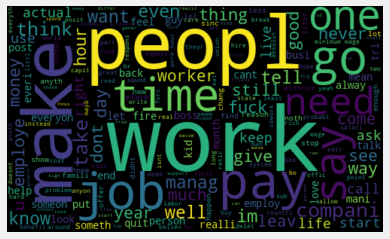

In [75]:
#word cloud and parameter
allwords = ' '.join(final_clean)
wordCloud = WordCloud(width = 500, height = 300, random_state = 21, max_font_size = 119).generate(allwords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show

In [76]:
#creating a column of tokenzied words using panda
pd_clean = pd.DataFrame(final_clean, columns=['Token'])

In [77]:
#defing sentiment anaylsis to determine whether the word is positive, negative, neutral
sia = SentimentIntensityAnalyzer()

#only taking the compound score
def sent_score(text):
    return sia.polarity_scores(text)['compound']

In [78]:
#using applymap to create a new column labeling the polarity score
pd_clean['Polarity'] = pd_clean['Token'].apply(sent_score)

In [79]:
#defing whether the word is positve:1, negative:0, or neutral:2
def sentiment(polarity):
    if polarity > 0:
        return 1
    elif polarity == 0:
        return 2
    else:
        return 0

In [80]:
#applying the labeling into each word while creating new column
pd_clean['Sentiment'] = pd_clean['Polarity'].apply(sentiment)

In [81]:
#filtering to only negative words to do an negative sentiment analysis
#can which to filter to 1 for positive, or 2 for netural and rerun the code
sent_words = pd_clean['Token'][pd_clean['Sentiment']==0]

In [82]:
#creating a list of all the negative words
all_sent_words = []

for word in sent_words:
    all_sent_words.append(word)
    

In [83]:
#calcualting all the frequence distribution of all the negative words
fdist = FreqDist(all_sent_words)
#then organizing it into a panda data frame
sent_df = pd.DataFrame({'Words':list(fdist.keys()),
                     'Count':list(fdist.values())})
#pw_df

<function matplotlib.pyplot.show(*args, **kw)>

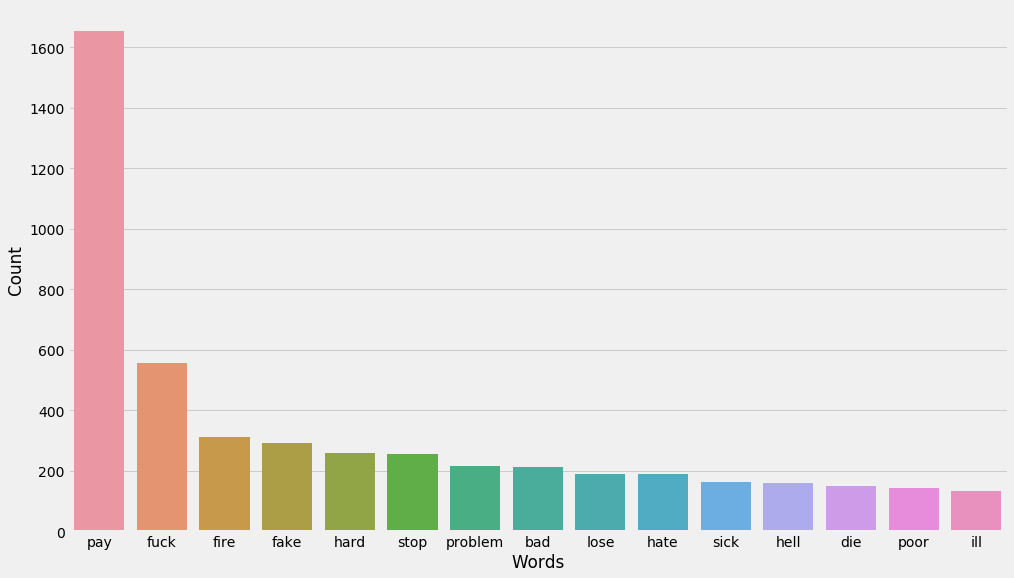

In [84]:
#setting the parameter for bar chart
sent_bar = sent_df.nlargest(columns='Count', n=15)

#setting parameter
plt.figure(figsize=(15,9))
sns.barplot(data=sent_bar,x='Words',y='Count')
plt.show

In [85]:
#setting up a list for bigram analysis
#consecutive words
w_bigrams = list(bigrams(final_clean))
bi_list = []
for a in w_bigrams:
    bi_list.append(list(a)) #making it into a list of items so i can unpack it later

In [86]:
#organzing the bigram list into a data frame
bg_df = pd.DataFrame({'Bis':bi_list})

In [87]:
#unpacking the bigrams in data frame
def unnest(nest):
    return ' '.join(nest)

In [88]:
#creating the unnested columns
bg_df['Bigrams'] = bg_df['Bis'].apply(unnest)

In [89]:
#labeling the bigrams with sentiment score
bg_df['Polarity'] = bg_df['Bigrams'].apply(sent_score)

In [90]:
#labeling the bigrams with 1 for positive, 0 for negative, 2 for neutral
bg_df['Sentiment'] = bg_df['Polarity'].apply(sentiment)

In [91]:
#filtering into negative bigrams only for analysis.
#can change the filter to 1 for positive, 2 for neutral
bi_sent_words = bg_df['Bigrams'][bg_df['Sentiment']==0]

In [92]:
#creating a list of all negative bigram words
all_bi_words = []
for word in bi_sent_words:
    all_bi_words.append(word)

In [93]:
#calcualting all the frequence distribution of all the negative bigrams
bi_fdist = FreqDist(all_bi_words)
biw_df = pd.DataFrame({'Words':list(bi_fdist.keys()),
                     'Count':list(bi_fdist.values())})
#biw_df

<function matplotlib.pyplot.show(*args, **kw)>

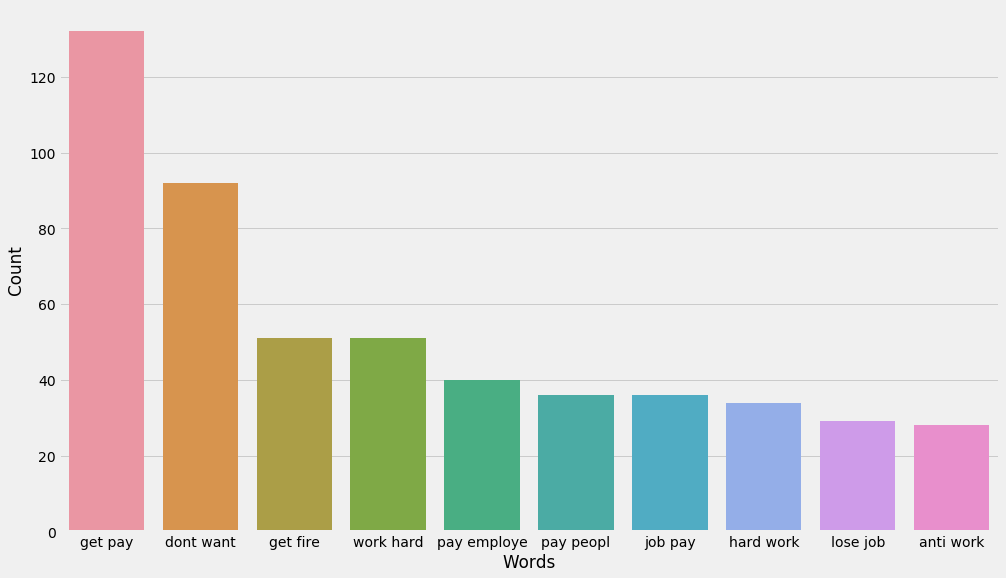

In [94]:
#setting the parameter to showing only top 10
biw_bar = biw_df.nlargest(columns='Count', n=10)

#bar chart parameters
plt.figure(figsize=(15,9))
sns.barplot(data=biw_bar,x='Words',y='Count')
plt.show

In [1]:
#ENDS HERE

In [ ]:
#rest are notes

In [23]:
fdist = FreqDist()
for word in final_clean:
    fdist[word]+=1
top_w = fdist.most_common(20)
top_w

[('work', 1870),
 ('get', 1406),
 ('peopl', 1113),
 ('pay', 918),
 ('make', 900),
 ('like', 783),
 ('job', 780),
 ('go', 747),
 ('time', 725),
 ('fuck', 666),
 ('would', 559),
 ('want', 523),
 ('hour', 516),
 ('one', 508),
 ('dont', 507),
 ('year', 501),
 ('say', 497),
 ('day', 483),
 ('need', 482),
 ('im', 446)]

In [60]:
w_bigrams = list(bigrams(final_clean))
fdbi = FreqDist()
for word in w_bigrams:
    fdbi[word]+=1
bi_top = fdbi.most_common(15)
bi_top

[(('minimum', 'wage'), 222),
 (('get', 'pay'), 131),
 (('hour', 'week'), 115),
 (('gon', 'na'), 114),
 (('feel', 'like'), 112),
 (('peopl', 'work'), 105),
 (('sound', 'like'), 99),
 (('want', 'work'), 99),
 (('dont', 'want'), 95),
 (('40', 'hour'), 95),
 (('go', 'back'), 92),
 (('live', 'wage'), 91),
 (('make', 'sure'), 82),
 (('year', 'ago'), 78),
 (('work', 'home'), 78)]

In [71]:
w_trigrams = list(trigrams(final_clean))
fdtri = FreqDist()
for word in w_trigrams:
    fdtri[word]+=1
tri_top = fdtri.most_common(10)
tri_top

[(('40', 'hour', 'week'), 40),
 (('work', '40', 'hour'), 33),
 (('pay', 'live', 'wage'), 25),
 (('work', 'full', 'time'), 24),
 (('imag', 'transcript', 'twitter'), 22),
 (('minimum', 'wage', 'job'), 22),
 (('hour', 'work', 'week'), 21),
 (('im', 'gon', 'na'), 19),
 (('full', 'time', 'job'), 19),
 (('go', 'back', 'work'), 18)]

In [ ]:
w_ngrams = list(ngrams(final_clean,4))
fdngram = FreqDist()
for word in w_ngrams:
    fdngram[word]+=1
ngram_top = fdngram.most_common(10)
ngram_top

In [18]:
sia = SentimentIntensityAnalyzer()

In [22]:
sia.polarity_scores("")

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [ ]:
#import re
#def remove_emojis(data):
#    emoj = re.compile("["
#        u"\U0001F600-\U0001F64F"  # emoticons
#        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#        u"\U0001F680-\U0001F6FF"  # transport & map symbols
#        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#        u"\U00002500-\U00002BEF"  # chinese char
#        u"\U00002702-\U000027B0"
#        u"\U00002702-\U000027B0"
#        u"\U000024C2-\U0001F251"
#        u"\U0001f926-\U0001f937"
#        u"\U00010000-\U0010ffff"
#        u"\u2640-\u2642" 
#        u"\u2600-\u2B55"
#        u"\u200d"
#        u"\u23cf"
#        u"\u23e9"
#        u"\u231a"
#        u"\ufe0f"  # dingbats
#        u"\u3030"
#                      "]+", re.UNICODE)
#    return re.sub(emoj, '', data)

In [ ]:
pd_comments.to_csv('Comment_data')

In [ ]:
submission = reddit.submission(url="https://www.reddit.com" + posts.link[0])

In [ ]:
submission.title

In [ ]:
#submission.comments.replace_more(limit=0)
submission.comment_sort = 'top'

In [ ]:
submission.comments.replace_more(limit=0)

In [ ]:
submission.comment_sort = 10

In [ ]:
comments = submission.comments.list()
len(comments)

In [ ]:
comments[11].body

In [ ]:
n = 0
for a in comments:
    if n <15:
        print(str(a.score)+ f': {n}')
    n+=1

In [ ]:
comments[11].body

In [ ]:
all_comments = list(submission.comments)

In [ ]:
comm_list = []
for comment in (all_comments):
    comm_list.append((comment.score,comment.id))

In [ ]:
submission.title

In [ ]:
posts.link[0]

In [ ]:
top_comms[0].

In [ ]:
#pprint.pprint(vars(top_comms[0])) to check methods and attributes related to an object of praws